# Mouse Cerebellar Layer Analysis
## Analysis of Cerebellar Layer Measurements for Control vs NEC Samples
This notebook analyzes measurements from different cerebellar layers (ML, IGL, EGL, WM) and creates comparisons between Control (C) and NEC (N) mouse samples.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set output directory
output_dir = Path('/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium_mus/output')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {output_dir}")

# Create a function to save figures
def save_figure(fig_name, fig=None, dpi=300):
    """Save the current figure as PDF in the output directory"""
    if fig is None:
        fig = plt.gcf()
    output_path = output_dir / f"{fig_name}.pdf"
    plt.savefig(output_path, format='pdf', dpi=dpi, bbox_inches='tight')
    print(f"Saved: {output_path.name}")

Output directory set to: /Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium_mus/output


## 2. Load and Initial Data Exploration

In [2]:
# Define file path
csv_file_path = '/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium_mus/measurements_MOUSE.csv'

# Load the data
print("Loading data from CSV file...")
df = pd.read_csv(csv_file_path)

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Loading data from CSV file...

Dataset shape: (220, 11)
Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Area µm^2', 'Perimeter µm']

First few rows:


,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Perimeter µm
0,C1M1B1_1.vsi - 20x_BF_01,005e9d66-f7e2-46e1-a5f6-c63e85aa047a,Annotation,2.0,IGL,Root object (Image),Geometry,3863.6,1101.10,1742532.9,19264.0
1,C1M1B1_1.vsi - 20x_BF_01,066b538f-79ef-4588-b5a8-ecbd850c6e4f,Annotation,NaN,WM,Root object (Image),Geometry,4338.6,5061.10,37718890.9,52356.8
2,C1M1B1_1.vsi - 20x_BF_01,3344aac1-7f1b-46f6-86ca-301547d9f07a,Annotation,1.0,EGL,Root object (Image),Geometry,3852.5,981.92,345161.3,21483.6
3,C1M1B1_1.vsi - 20x_BF_01,74b6cea9-e573-4894-95f9-008d974474cd,Annotation,3.0,ML,Root object (Image),Geometry,3825.2,1065.80,1027932.9,26435.0
4,C1M1B1_1.vsi - 20x_BF_01,d1b46a65-f07c-468f-a0ba-645dbf4f7beb,Annotation,3.0,ML_IGL_20uM,Root object (Image),Geometry,3824.9,1032.10,258992.5,25748.9


In [3]:
#show all records containng Image as strin 8a in the df
image_records = df[df['Image'].astype(str).str.contains('8a', na=False)]

## 3. Data Preprocessing
### 3.1 Exclude 60x Images and Extract Sample Information

In [4]:
# First, let's see how many 60x vs 20x images we have
print("Image magnification distribution:")
print(df['Image'].str.contains('60x').value_counts())

# Exclude 60x images
print(f"\nNumber of rows before excluding 60x images: {len(df)}")
df = df[~df['Image'].str.contains('60x')]
print(f"Number of rows after excluding 60x images: {len(df)}")

# Extract sample name from Image column
# Updated pattern to handle both formats:
# 1. 'C1M1B1_1.vsi - 20x_BF_01' -> Sample: 'C1M1B1', Image_num: '1'
# 2. 'C1M1B1_8a.vsi - 20x_BF_01' -> Sample: 'C1M1B1', Image_num: '8a'
# 3. 'C2M3B1_H&E_20x.vsi - 20x_BF_01' -> Sample: 'C2M3B1', Image_num: '0' (default)

# Extract the base sample name (e.g., C1M1B1, C2M3B1, N1M1B1)
df['Sample_full'] = df['Image'].str.extract(r'([CN]\d+M\d+B\d+)', expand=False)

# Try to extract image number if it exists (pattern: sample_number.vsi or sample_numberletter.vsi)
# Updated pattern to capture digits followed by optional letters
df['Image_num'] = df['Image'].str.extract(r'[CN]\d+M\d+B\d+_(\d+[a-zA-Z]?)\.vsi', expand=False)

# For samples without image number (like C2M3B1_H&E_20x.vsi), assign '0'
df['Image_num'] = df['Image_num'].fillna('0')

# Extract sample type (C = Control, N = NEC)
df['Sample_type'] = df['Sample_full'].str[0].map({'C': 'Control', 'N': 'NEC'})

# Display the extraction results
print("\nSample extraction results:")
print(df[['Image', 'Sample_full', 'Image_num', 'Sample_type']].head(10))

# Show unique image patterns to verify extraction
print("\nUnique image patterns found:")
unique_patterns = df.groupby(['Sample_full', 'Image_num']).size().reset_index(name='count')
print("\nCount of measurements per sample and image:")
print(unique_patterns.to_string(index=False))

# Also show summary statistics
print(f"\nSummary:")
print(f"Total unique sample-image combinations: {len(unique_patterns)}")
print(f"Average measurements per sample-image: {unique_patterns['count'].mean():.1f}")
print(f"Range: {unique_patterns['count'].min()} - {unique_patterns['count'].max()} measurements")

# Show which samples have multiple images
multi_image_samples = unique_patterns.groupby('Sample_full').size()
multi_image_samples = multi_image_samples[multi_image_samples > 1]
if len(multi_image_samples) > 0:
    print(f"\nSamples with multiple images:")
    for sample, img_count in multi_image_samples.items():
        print(f"  {sample}: {img_count} images")

# Check unique samples
unique_samples = df['Sample_full'].unique()
print(f"\nUnique samples found: {len(unique_samples)}")
print("Samples:", sorted(unique_samples))

# Check sample distribution
print("\nSample type distribution:")
print(df.groupby('Sample_type')['Sample_full'].nunique())

Image magnification distribution:
Image
False    200
True      20
Name: count, dtype: int64

Number of rows before excluding 60x images: 220
Number of rows after excluding 60x images: 200

Sample extraction results:
                       Image Sample_full Image_num Sample_type
0   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
1   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
2   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
3   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
4   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
15  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
16  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
17  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
18  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
19  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control

Unique image patterns found:

Count of measurements per sample and image:
Sample_full Imag

### 3.2 Clean Column Names and Check Classifications

In [5]:
# Rename columns to remove units for easier handling
df = df.rename(columns={
    'Area µm^2': 'Area',
    'Perimeter µm': 'Perimeter',
    'Centroid X µm': 'Centroid_X',
    'Centroid Y µm': 'Centroid_Y'
})

print("Column names cleaned.")

# Check unique classifications
print("\nUnique classifications in the dataset:")
classifications = df['Classification'].unique()
print(classifications)

# Check for ML_IGL_20uM (equivalent to ML_IGL_150uM in human data)
if 'ML_IGL_20uM' in classifications:
    print("\nML_IGL_20uM found - will use for perimeter normalization")
    ml_igl_count = len(df[df['Classification'] == 'ML_IGL_20uM'])
    print(f"Number of ML_IGL_20uM measurements: {ml_igl_count}")

Column names cleaned.

Unique classifications in the dataset:
['IGL' 'WM' 'EGL' 'ML' 'ML_IGL_20uM']

ML_IGL_20uM found - will use for perimeter normalization
Number of ML_IGL_20uM measurements: 40


### 3.3 List All Control and NEC Subjects for Verification

In [6]:
print("\n" + "="*60)
print("SUBJECT VERIFICATION")
print("="*60)

control_subjects = sorted(df[df['Sample_type'] == 'Control']['Sample_full'].unique())
nec_subjects = sorted(df[df['Sample_type'] == 'NEC']['Sample_full'].unique())

print(f"\nCONTROL SUBJECTS (n={len(control_subjects)}):")
for subject in control_subjects:
    subject_data = df[df['Sample_full'] == subject]
    unique_images = subject_data['Image_num'].unique()
    # Show example image names to verify extraction
    example_image = subject_data['Image'].iloc[0]
    print(f"  - {subject}: {len(unique_images)} image(s) [Image nums: {sorted(unique_images)}]")
    print(f"    Example: {example_image}")

print(f"\nNEC SUBJECTS (n={len(nec_subjects)}):")
for subject in nec_subjects:
    subject_data = df[df['Sample_full'] == subject]
    unique_images = subject_data['Image_num'].unique()
    example_image = subject_data['Image'].iloc[0]
    print(f"  - {subject}: {len(unique_images)} image(s) [Image nums: {sorted(unique_images)}]")
    print(f"    Example: {example_image}")

# Show summary of image naming patterns
print("\n" + "-"*60)
print("IMAGE NAMING PATTERNS DETECTED:")
print("-"*60)

# Group by whether Image_num is '0' (no suffix) or has a number
has_number = df[df['Image_num'] != '0'].shape[0]
no_number = df[df['Image_num'] == '0'].shape[0]

print(f"Images with numbered suffix (e.g., C1M1B1_1.vsi): {has_number}")
print(f"Images without numbered suffix (e.g., C2M3B1_H&E_20x.vsi): {no_number}")

print("\n" + "="*60)



SUBJECT VERIFICATION

CONTROL SUBJECTS (n=8):
  - C1M1B1: 1 image(s) [Image nums: ['1']]
    Example: C1M1B1_1.vsi - 20x_BF_01
  - C1M2B1: 2 image(s) [Image nums: ['1', '2']]
    Example: C1M2B1_1.vsi - 20x_BF_01
  - C1M3B1: 2 image(s) [Image nums: ['1', '2']]
    Example: C1M3B1_1.vsi - 20x_BF_01
  - C1M4B1: 2 image(s) [Image nums: ['1', '2']]
    Example: C1M4B1_1.vsi - 20x_BF_01
  - C2M1B1: 1 image(s) [Image nums: ['0']]
    Example: C2M1B1_7_H&E_20x.vsi - 20x_BF_01
  - C2M2B1: 1 image(s) [Image nums: ['0']]
    Example: C2M2B1_4_H&E_20x.vsi - 20x_BF_01
  - C2M3B1: 1 image(s) [Image nums: ['0']]
    Example: C2M3B1_H&E_20x.vsi - 20x_BF_01
  - C2M5B1: 1 image(s) [Image nums: ['0']]
    Example: C2M5B1_11_H&E_20x.vsi - 20x_BF_01

NEC SUBJECTS (n=9):
  - N11M1B2: 4 image(s) [Image nums: ['1', '2', '8a', '8b']]
    Example: N11M1B2_1.vsi - 20x_BF_01
  - N11M2B1: 6 image(s) [Image nums: ['2a', '2b', '3a', '3b', '4a', '4b']]
    Example: N11M2B1_2a.vsi - 20x_BF_01
  - N11M3B1: 1 image(s)

### 3.4 Optional: Exclude Specific Sample IDs

In [7]:
# Define samples to exclude (if any)
# Add sample IDs to this list if they need to be excluded from analysis
SAMPLES_TO_EXCLUDE = ['C2M1B1']  # Example: ['C1M1B1', 'N2M3B2']

if SAMPLES_TO_EXCLUDE:
    print(f"\nExcluding the following samples from analysis: {SAMPLES_TO_EXCLUDE}")
    print(f"Rows before exclusion: {len(df)}")
    
    # Remove specified samples
    df = df[~df['Sample_full'].isin(SAMPLES_TO_EXCLUDE)]
    
    print(f"Rows after exclusion: {len(df)}")
    
    # Show updated sample counts
    print("\nUpdated sample counts:")
    print(df.groupby('Sample_type')['Sample_full'].nunique())
    
    # List remaining samples
    remaining_control = sorted(df[df['Sample_type'] == 'Control']['Sample_full'].unique())
    remaining_nec = sorted(df[df['Sample_type'] == 'NEC']['Sample_full'].unique())
    
    print(f"\nRemaining Control samples: {remaining_control}")
    print(f"Remaining NEC samples: {remaining_nec}")
else:
    print("\nNo samples excluded - analyzing all samples")


Excluding the following samples from analysis: ['C2M1B1']
Rows before exclusion: 200
Rows after exclusion: 195

Updated sample counts:
Sample_type
Control    7
NEC        9
Name: Sample_full, dtype: int64

Remaining Control samples: ['C1M1B1', 'C1M2B1', 'C1M3B1', 'C1M4B1', 'C2M2B1', 'C2M3B1', 'C2M5B1']
Remaining NEC samples: ['N11M1B2', 'N11M2B1', 'N11M3B1', 'N11M3B2', 'N11M6B1', 'N11M6B2', 'N12M5B1', 'N13M2B1', 'N13M3B1']


## 4. Calculate Normalized Areas

In [8]:
def calculate_normalized_areas_mouse(df):
    """
    Calculate normalized areas for all layers using ML_IGL_20uM perimeter as reference.
    
    For each sample and image:
    - Use ML_IGL_20uM perimeter / 2 as the normalization factor
    - Calculate area / (ML_IGL_20uM perimeter / 2) for each layer
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with normalized areas for each sample and image
    """
    # First, create a unique identifier for each sample-image combination
    df = df.copy()  # Work with a copy to avoid modifying the original
    df['Sample_Image'] = df['Sample_full'] + '_' + df['Image_num'].fillna('0')
    
    # Get ML_IGL_20uM perimeter for each sample-image combination
    ml_igl_data = df[df['Classification'] == 'ML_IGL_20uM'].copy()
    
    if len(ml_igl_data) == 0:
        print("Error: No ML_IGL_20uM data found. Cannot normalize.")
        return pd.DataFrame()
    
    # Get ML_IGL_20uM perimeter for each sample-image
    ml_igl_perimeters = ml_igl_data.set_index('Sample_Image')['Perimeter']
    ml_igl_lengths = ml_igl_perimeters / 2
    
    print(f"Found ML_IGL_20uM perimeter data for {len(ml_igl_lengths)} sample-image combinations")
    
    # Check for missing ML_IGL_20uM data
    all_sample_images = df['Sample_Image'].unique()
    missing_ml_igl = set(all_sample_images) - set(ml_igl_lengths.index)
    if missing_ml_igl:
        print(f"Warning: {len(missing_ml_igl)} sample-images missing ML_IGL_20uM data")
    
    # Initialize results list
    results = []
    
    # For each layer, calculate normalized area
    layers = ['ML', 'IGL', 'EGL', 'WM']
    
    for idx, row in df.iterrows():
        if row['Classification'] in layers:
            sample_image = row['Sample_Image']
            
            if sample_image in ml_igl_lengths:
                try:
                    # Ensure numeric values
                    area = float(row['Area'])
                    length = float(ml_igl_lengths[sample_image])
                    
                    if length > 0:  # Avoid division by zero
                        normalized_area = area / length
                        
                        results.append({
                            'Sample_full': row['Sample_full'],
                            'Sample_type': row['Sample_type'],
                            'Image_num': row['Image_num'],
                            'Sample_Image': sample_image,
                            'Layer': row['Classification'],
                            'Area': area,
                            'ML_IGL_20uM_length': length,
                            'Normalized_Area': normalized_area
                        })
                    else:
                        print(f"Warning: Zero length for {sample_image}")
                except (ValueError, TypeError) as e:
                    print(f"Warning: Could not process {sample_image}, {row['Classification']}: {e}")
            else:
                # Track samples without ML_IGL_20uM reference
                if idx < 5:  # Only print first few warnings
                    print(f"Note: No ML_IGL_20uM reference for {sample_image}")
    
    print(f"\nSuccessfully normalized {len(results)} measurements")
    return pd.DataFrame(results)

# Calculate normalized areas
print("Calculating normalized areas using ML_IGL_20uM perimeter as reference...")
normalized_df = calculate_normalized_areas_mouse(df)

if len(normalized_df) > 0:
    print(f"\nNormalized data created with {len(normalized_df)} measurements")
    
    # Check data types and convert if necessary
    print("\nData type check:")
    print(f"Normalized_Area dtype: {normalized_df['Normalized_Area'].dtype}")
    
    # Ensure Normalized_Area is numeric
    normalized_df['Normalized_Area'] = pd.to_numeric(normalized_df['Normalized_Area'], errors='coerce')
    
    # Check for any NaN values after conversion
    nan_count = normalized_df['Normalized_Area'].isna().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values found in Normalized_Area")
        print("Samples with NaN values:")
        print(normalized_df[normalized_df['Normalized_Area'].isna()][['Sample_full', 'Layer', 'Sample_Image']])
    
    # Display statistics by layer
    print("\nStatistics by layer:")
    for layer in ['ML', 'IGL', 'EGL', 'WM']:
        layer_data = normalized_df[normalized_df['Layer'] == layer]
        if len(layer_data) > 0:
            # Remove NaN values for statistics
            valid_data = layer_data['Normalized_Area'].dropna()
            if len(valid_data) > 0:
                print(f"\n{layer}:")
                print(f"  Count: {len(valid_data)} (out of {len(layer_data)} total)")
                print(f"  Mean normalized area: {valid_data.mean():.2f}")
                print(f"  Std: {valid_data.std():.2f}")
            else:
                print(f"\n{layer}: No valid normalized values")

Calculating normalized areas using ML_IGL_20uM perimeter as reference...
Found ML_IGL_20uM perimeter data for 39 sample-image combinations

Successfully normalized 152 measurements

Normalized data created with 152 measurements

Data type check:
Normalized_Area dtype: float64

Statistics by layer:

ML:
  Count: 38 (out of 38 total)
  Mean normalized area: 53.77
  Std: 15.84

IGL:
  Count: 38 (out of 38 total)
  Mean normalized area: 107.98
  Std: 17.53

EGL:
  Count: 38 (out of 38 total)
  Mean normalized area: 30.47
  Std: 6.91

WM:
  Count: 38 (out of 38 total)
  Mean normalized area: 2682.57
  Std: 489.28


## 5. Average Multiple Images per Sample

In [9]:
# Average normalized areas across multiple images for the same sample
print("Averaging multiple images per sample...")

averaged_df = normalized_df.groupby(['Sample_full', 'Sample_type', 'Layer']).agg({
    'Normalized_Area': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
averaged_df.columns = ['Sample_full', 'Sample_type', 'Layer', 'Normalized_Area_mean', 
                       'Normalized_Area_std', 'Image_count']

# Show samples with multiple images
multi_image_samples = averaged_df[averaged_df['Image_count'] > 1]
if len(multi_image_samples) > 0:
    print("\nSamples with multiple images (averaged):")
    print(multi_image_samples[['Sample_full', 'Layer', 'Image_count', 
                               'Normalized_Area_mean', 'Normalized_Area_std']])

# Pivot to get layers as columns
pivoted_df = averaged_df.pivot(index=['Sample_full', 'Sample_type'], 
                               columns='Layer', 
                               values='Normalized_Area_mean').reset_index()

print(f"\nFinal dataset shape: {pivoted_df.shape}")
print(pivoted_df.head())

Averaging multiple images per sample...

Samples with multiple images (averaged):
   Sample_full Layer  Image_count  Normalized_Area_mean  Normalized_Area_std
4       C1M2B1   EGL            2             22.923412             0.507635
5       C1M2B1   IGL            2            118.507700             1.852367
6       C1M2B1    ML            2             80.313228             3.120017
7       C1M2B1    WM            2           3427.378456            74.414009
8       C1M3B1   EGL            2             19.622061             1.564836
9       C1M3B1   IGL            2            104.326902             0.117695
10      C1M3B1    ML            2             68.379136             6.961158
11      C1M3B1    WM            2           3069.021268           311.208094
12      C1M4B1   EGL            2             26.019250             2.752602
13      C1M4B1   IGL            2            126.982725             8.290954
14      C1M4B1    ML            2             85.344808             7.7

## 6. Create Individual Layer Heatmaps (Control vs NEC)

Saved: ML_layer_heatmap_by_type.pdf


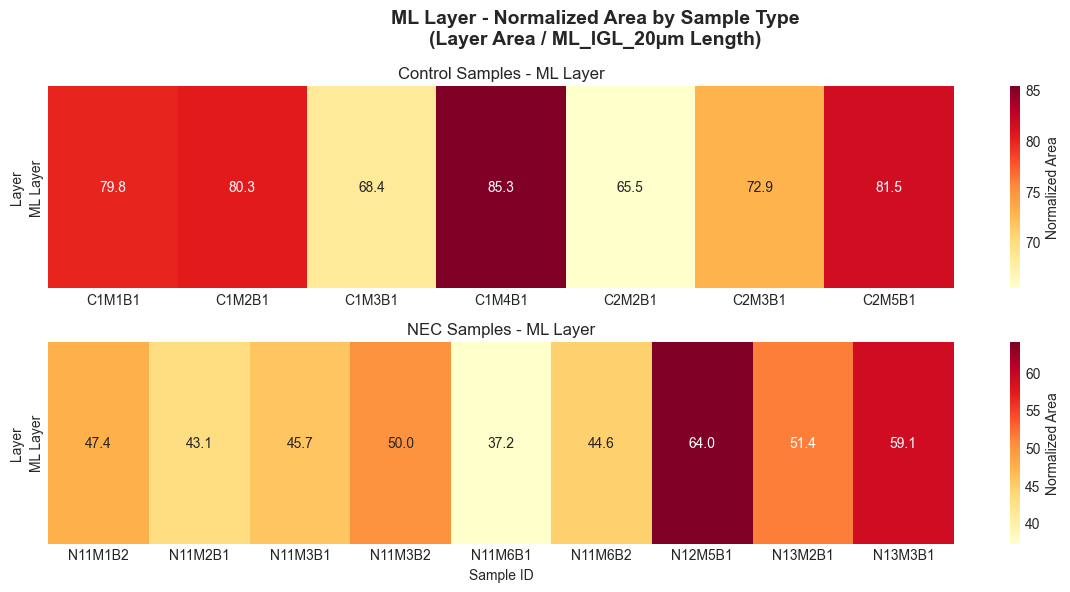

Saved: IGL_layer_heatmap_by_type.pdf


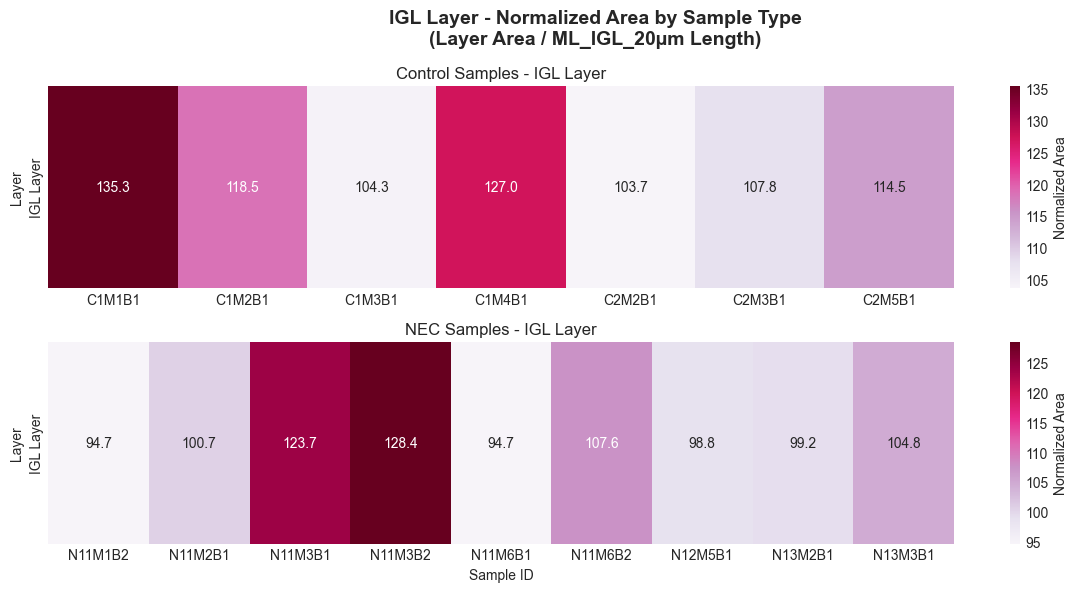

Saved: EGL_layer_heatmap_by_type.pdf


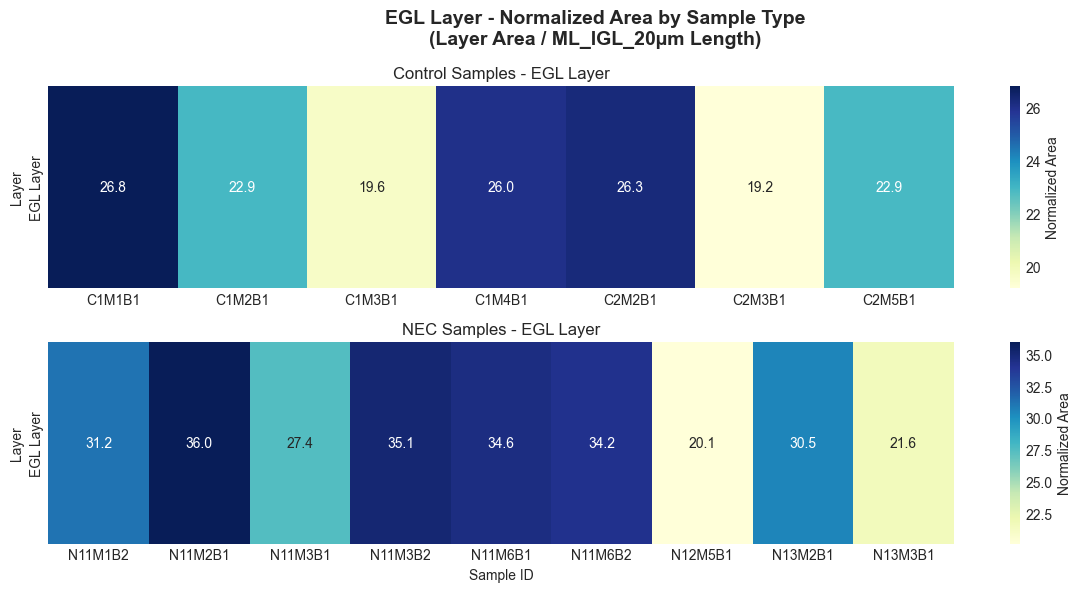

Saved: WM_layer_heatmap_by_type.pdf


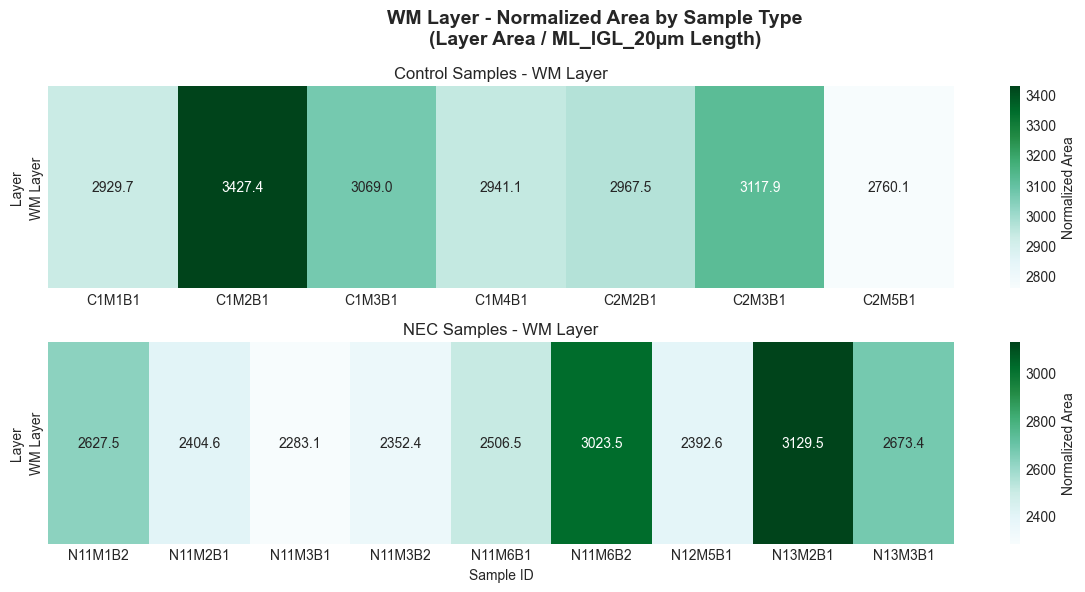

In [10]:
# Define color schemes for each layer
color_schemes = {
    'ML': 'YlOrRd',     # Yellow to Orange to Red
    'IGL': 'PuRd',      # Purple to Red
    'EGL': 'YlGnBu',    # Yellow to Green to Blue
    'WM': 'BuGn'        # Blue to Green
}

# Create heatmaps for each layer separated by sample type
for layer in ['ML', 'IGL', 'EGL', 'WM']:
    if layer not in pivoted_df.columns:
        print(f"\nSkipping {layer} - no data available")
        continue
    
    # Prepare data for both sample types
    control_data = pivoted_df[pivoted_df['Sample_type'] == 'Control'][['Sample_full', layer]].dropna()
    nec_data = pivoted_df[pivoted_df['Sample_type'] == 'NEC'][['Sample_full', layer]].dropna()
    
    if len(control_data) == 0 and len(nec_data) == 0:
        print(f"\nNo data available for {layer} layer")
        continue
    
    # Create figure with subplots for Control and NEC
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    # Control heatmap
    if len(control_data) > 0:
        control_matrix = control_data.set_index('Sample_full')[[layer]].T
        sns.heatmap(control_matrix,
                    cmap=color_schemes[layer],
                    annot=True,
                    fmt='.1f',
                    cbar_kws={'label': 'Normalized Area'},
                    ax=ax1,
                    xticklabels=True,
                    yticklabels=[f'{layer} Layer'])
        ax1.set_title(f'Control Samples - {layer} Layer', fontsize=12)
        ax1.set_xlabel('')
    
    # NEC heatmap
    if len(nec_data) > 0:
        nec_matrix = nec_data.set_index('Sample_full')[[layer]].T
        sns.heatmap(nec_matrix,
                    cmap=color_schemes[layer],
                    annot=True,
                    fmt='.1f',
                    cbar_kws={'label': 'Normalized Area'},
                    ax=ax2,
                    xticklabels=True,
                    yticklabels=[f'{layer} Layer'])
        ax2.set_title(f'NEC Samples - {layer} Layer', fontsize=12)
        ax2.set_xlabel('Sample ID')
    
    plt.suptitle(f'{layer} Layer - Normalized Area by Sample Type\n(Layer Area / ML_IGL_20µm Length)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save figure
    save_figure(f'{layer}_layer_heatmap_by_type')
    plt.show()


## 7. Create Combined Heatmap Comparing Control vs NEC

Saved: combined_heatmap_control_nec_actual_values.pdf


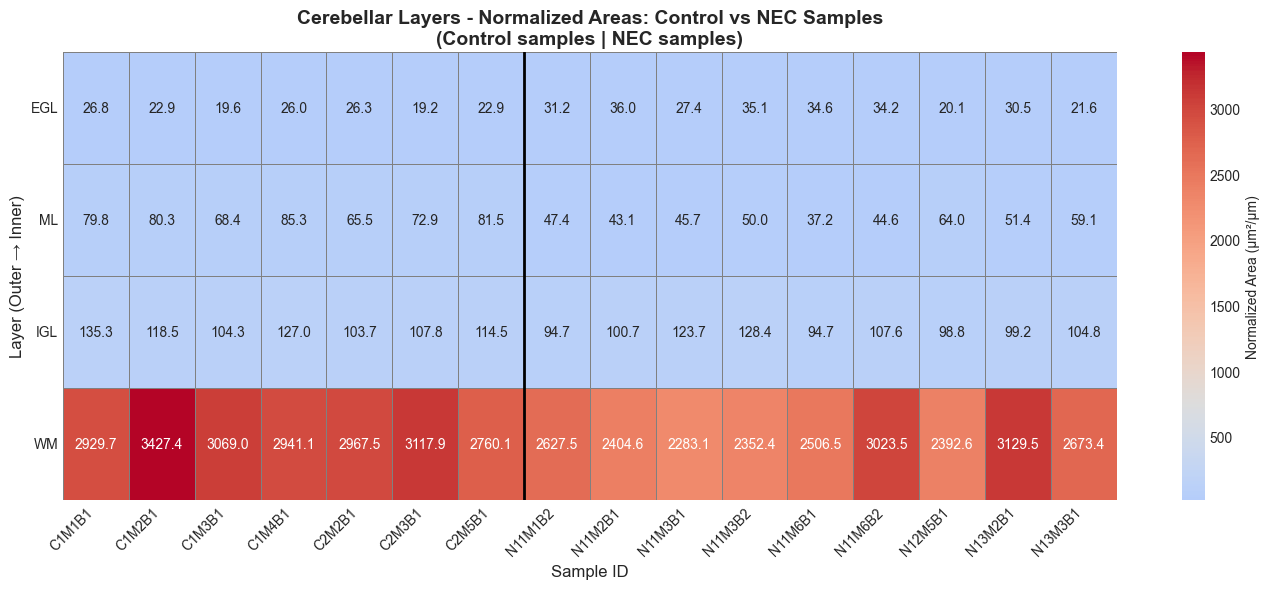

Saved: combined_heatmap_control_nec_row_normalized.pdf


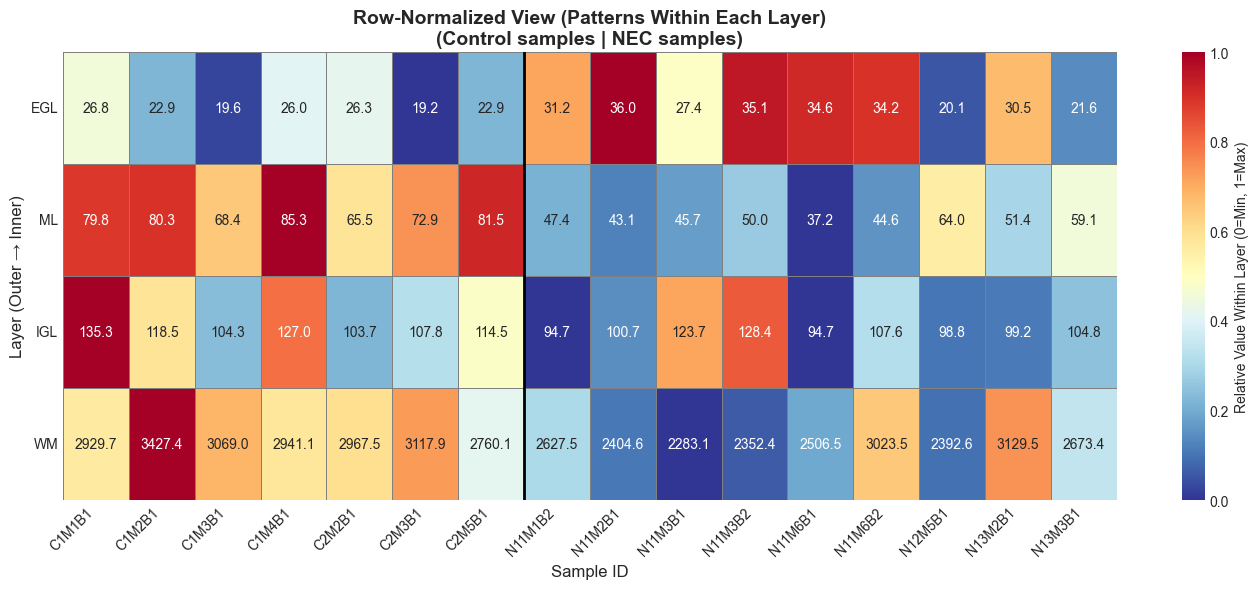


Heatmap Summary:
------------------------------------------------------------
Control samples (left side): 7
Control IDs: C1M1B1, C1M2B1, C1M3B1, C1M4B1, C2M2B1, C2M3B1, C2M5B1

NEC samples (right side): 9
NEC IDs: N11M1B2, N11M2B1, N11M3B1, N11M3B2, N11M6B1, N11M6B2, N12M5B1, N13M2B1, N13M3B1

Layer Statistics:

EGL Layer:
  Control: Mean=23.39, Range=19.21-26.81
  NEC: Mean=30.07, Range=20.09-35.97

ML Layer:
  Control: Mean=76.25, Range=65.49-85.34
  NEC: Mean=49.16, Range=37.22-64.01

IGL Layer:
  Control: Mean=115.89, Range=103.72-135.35
  NEC: Mean=105.83, Range=94.66-128.43

WM Layer:
  Control: Mean=3030.39, Range=2760.07-3427.38
  NEC: Mean=2599.22, Range=2283.06-3129.46


In [11]:
# Prepare data for combined heatmap
heatmap_data = pivoted_df.copy()

# Sort samples: Control first (sorted by ID), then NEC (sorted by ID)
control_data = heatmap_data[heatmap_data['Sample_type'] == 'Control'].sort_values('Sample_full')
nec_data = heatmap_data[heatmap_data['Sample_type'] == 'NEC'].sort_values('Sample_full')

# Combine Control and NEC data
combined_data = pd.concat([control_data, nec_data])

# Define layer order (anatomical: outer to inner)
layer_order = ['EGL', 'ML', 'IGL', 'WM']

# Create matrix for heatmap
heatmap_matrix = combined_data.set_index('Sample_full')[layer_order].T

# Create the actual values heatmap
plt.figure(figsize=(14, 6))

# Create heatmap with actual values
sns.heatmap(heatmap_matrix,
            cmap='coolwarm',
            annot=True,
            fmt='.1f',
            cbar_kws={'label': 'Normalized Area (µm²/µm)'},
            linewidths=0.5,
            linecolor='gray',
            center=heatmap_matrix.mean().mean())

# Add vertical line to separate Control and NEC
if len(control_data) > 0 and len(nec_data) > 0:
    plt.axvline(x=len(control_data), color='black', linewidth=2)

plt.title('Cerebellar Layers - Normalized Areas: Control vs NEC Samples\n(Control samples | NEC samples)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Sample ID', fontsize=12)
plt.ylabel('Layer (Outer → Inner)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Keep simple layer labels
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)

plt.tight_layout()

# Save figure
save_figure('combined_heatmap_control_nec_actual_values')

plt.show()

# Create row-normalized heatmap (to show patterns within each layer)
plt.figure(figsize=(14, 6))

# Normalize each layer separately for better visualization
heatmap_normalized = heatmap_matrix.copy()
for layer in heatmap_normalized.index:
    row_values = heatmap_normalized.loc[layer]
    row_min = row_values.min()
    row_max = row_values.max()
    if row_max > row_min:
        heatmap_normalized.loc[layer] = (row_values - row_min) / (row_max - row_min)

# Create row-normalized heatmap
sns.heatmap(heatmap_normalized,
            cmap='RdYlBu_r',
            annot=heatmap_matrix.values,  # Show original values
            fmt='.1f',
            cbar_kws={'label': 'Relative Value Within Layer (0=Min, 1=Max)'},
            linewidths=0.5,
            linecolor='gray')

# Add vertical line to separate Control and NEC
if len(control_data) > 0 and len(nec_data) > 0:
    plt.axvline(x=len(control_data), color='black', linewidth=2)

plt.title('Row-Normalized View (Patterns Within Each Layer)\n(Control samples | NEC samples)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Sample ID', fontsize=12)
plt.ylabel('Layer (Outer → Inner)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Keep simple layer labels
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)

plt.tight_layout()

# Save figure
save_figure('combined_heatmap_control_nec_row_normalized')

plt.show()

# Print information about the heatmap
print("\nHeatmap Summary:")
print("-" * 60)
print(f"Control samples (left side): {len(control_data)}")
if len(control_data) > 0:
    control_sample_names = control_data['Sample_full'].tolist()
    print(f"Control IDs: {', '.join(control_sample_names)}")

print(f"\nNEC samples (right side): {len(nec_data)}")
if len(nec_data) > 0:
    nec_sample_names = nec_data['Sample_full'].tolist()
    print(f"NEC IDs: {', '.join(nec_sample_names)}")

# Print layer statistics for context
print("\nLayer Statistics:")
for layer in layer_order:
    if layer in heatmap_matrix.index:
        # Get sample names from the heatmap matrix columns
        all_samples = heatmap_matrix.columns
        control_samples = [s for s in all_samples if s in control_data.set_index('Sample_full').index]
        nec_samples = [s for s in all_samples if s in nec_data.set_index('Sample_full').index]
        
        if control_samples:
            control_values = heatmap_matrix.loc[layer, control_samples]
            print(f"\n{layer} Layer:")
            print(f"  Control: Mean={control_values.mean():.2f}, Range={control_values.min():.2f}-{control_values.max():.2f}")
        
        if nec_samples:
            nec_values = heatmap_matrix.loc[layer, nec_samples]
            if not control_samples:  # Only print layer name if not already printed
                print(f"\n{layer} Layer:")
            print(f"  NEC: Mean={nec_values.mean():.2f}, Range={nec_values.min():.2f}-{nec_values.max():.2f}")


## 8. Statistical Analysis: Control vs NEC Comparison

Saved: control_vs_nec_boxplot_all_layers.pdf


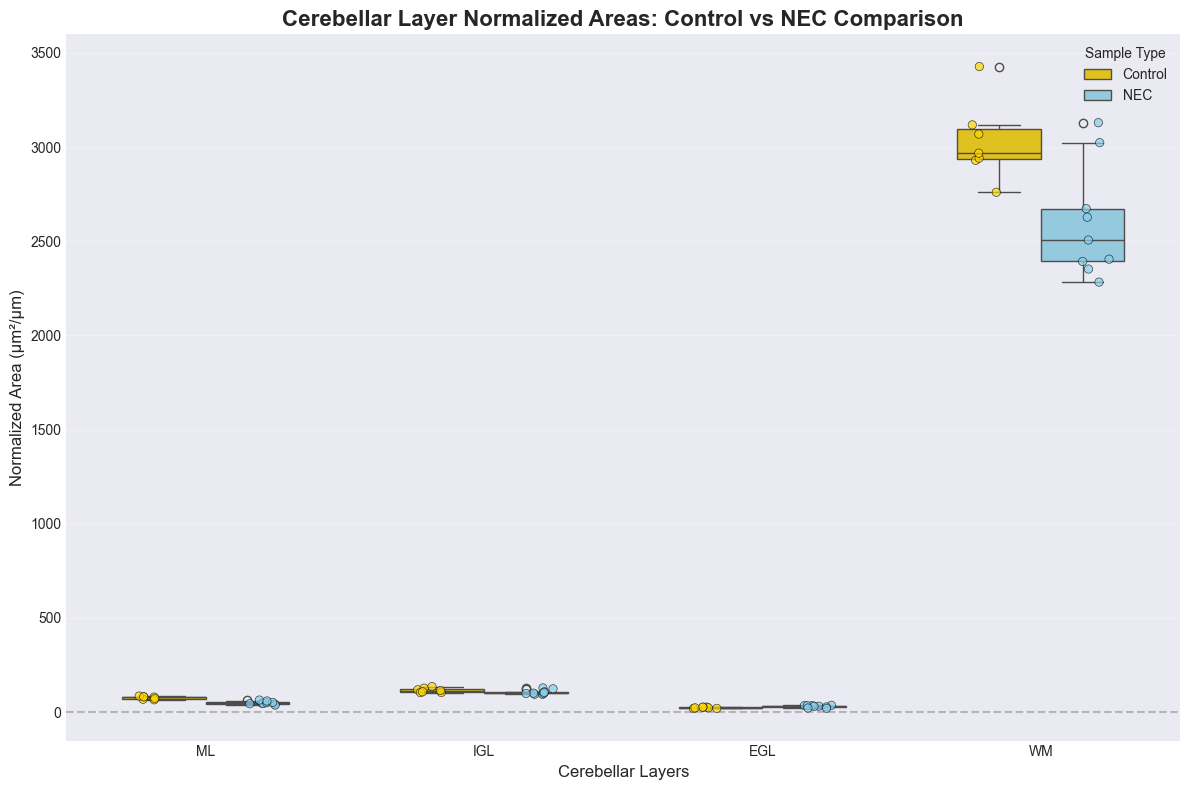

In [12]:
# Prepare data for box plots
melted_df = pivoted_df.melt(id_vars=['Sample_full', 'Sample_type'], 
                           value_vars=['ML', 'IGL', 'EGL', 'WM'],
                           var_name='Layer', 
                           value_name='Normalized_Area')
melted_df = melted_df.dropna()

# Create box plot comparing Control vs NEC for all layers
plt.figure(figsize=(12, 8))

# Use the same color palette as the provided example
palette = {'Control': '#FFD700', 'NEC': '#87CEEB'}  # Gold for Control, Sky Blue for NEC

# Create box plot
ax = sns.boxplot(data=melted_df, 
                x='Layer', 
                y='Normalized_Area',
                hue='Sample_type',
                palette=palette,
                width=0.6)

# Add individual points
sns.stripplot(data=melted_df,
             x='Layer',
             y='Normalized_Area',
             hue='Sample_type',
             dodge=True,
             palette=palette,
             size=6,
             alpha=0.7,
             edgecolor='black',
             linewidth=0.5,
             ax=ax)

# Customize plot
plt.title('Cerebellar Layer Normalized Areas: Control vs NEC Comparison', 
         fontsize=16, fontweight='bold')
plt.xlabel('Cerebellar Layers', fontsize=12)
plt.ylabel('Normalized Area (µm²/µm)', fontsize=12)

# Add horizontal line at y=1.0 (reference line)
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Sample Type', loc='upper right')

# Add grid
plt.grid(True, alpha=0.3, axis='y')

# Adjust layout
plt.tight_layout()

# Save figure
save_figure('control_vs_nec_boxplot_all_layers')
plt.show()


## 9. Statistical Analysis: Control vs NEC Comparison

In [13]:
print("Statistical Analysis: Control vs NEC Comparison")
print("="*60)

# Perform statistical tests for each layer
for layer in ['ML', 'IGL', 'EGL', 'WM']:
    layer_data = melted_df[melted_df['Layer'] == layer]
    control_values = layer_data[layer_data['Sample_type'] == 'Control']['Normalized_Area']
    nec_values = layer_data[layer_data['Sample_type'] == 'NEC']['Normalized_Area']
    
    if len(control_values) > 0 and len(nec_values) > 0:
        print(f"\n{layer} Layer:")
        print(f"  Control: n={len(control_values)}, mean={control_values.mean():.3f}, std={control_values.std():.3f}")
        print(f"  NEC: n={len(nec_values)}, mean={nec_values.mean():.3f}, std={nec_values.std():.3f}")
        
        # Check normality
        if len(control_values) >= 3:
            _, p_control = stats.shapiro(control_values)
            print(f"  Control normality (Shapiro-Wilk): p={p_control:.3f}")
        
        if len(nec_values) >= 3:
            _, p_nec = stats.shapiro(nec_values)
            print(f"  NEC normality (Shapiro-Wilk): p={p_nec:.3f}")
        
        # Perform appropriate test
        if len(control_values) >= 3 and len(nec_values) >= 3:
            # Use Mann-Whitney U test (non-parametric)
            statistic, p_value = stats.mannwhitneyu(control_values, nec_values, alternative='two-sided')
            print(f"  Mann-Whitney U test: U={statistic:.3f}, p={p_value:.3f}")
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((control_values.std()**2 + nec_values.std()**2) / 2)
            if pooled_std > 0:
                cohens_d = (control_values.mean() - nec_values.mean()) / pooled_std
                print(f"  Cohen's d: {cohens_d:.3f}")
            
            # Significance markers for plotting
            if p_value < 0.001:
                sig_marker = "***"
            elif p_value < 0.01:
                sig_marker = "**"
            elif p_value < 0.05:
                sig_marker = "*"
            else:
                sig_marker = "ns"
            print(f"  Significance: {sig_marker}")


Statistical Analysis: Control vs NEC Comparison

ML Layer:
  Control: n=7, mean=76.252, std=7.403
  NEC: n=9, mean=49.160, std=8.215
  Control normality (Shapiro-Wilk): p=0.474
  NEC normality (Shapiro-Wilk): p=0.745
  Mann-Whitney U test: U=63.000, p=0.000
  Cohen's d: 3.465
  Significance: ***

IGL Layer:
  Control: n=7, mean=115.886, std=11.957
  NEC: n=9, mean=105.831, std=12.262
  Control normality (Shapiro-Wilk): p=0.466
  NEC normality (Shapiro-Wilk): p=0.042
  Mann-Whitney U test: U=48.000, p=0.091
  Cohen's d: 0.830
  Significance: ns

EGL Layer:
  Control: n=7, mean=23.391, std=3.135
  NEC: n=9, mean=30.065, std=5.892
  Control normality (Shapiro-Wilk): p=0.209
  NEC normality (Shapiro-Wilk): p=0.108
  Mann-Whitney U test: U=10.000, p=0.023
  Cohen's d: -1.414
  Significance: *

WM Layer:
  Control: n=7, mean=3030.388, std=208.916
  NEC: n=9, mean=2599.223, std=299.476
  Control normality (Shapiro-Wilk): p=0.470
  NEC normality (Shapiro-Wilk): p=0.142
  Mann-Whitney U test: U

## 10. Create Individual Box Plots for Each Layer

Saved: individual_layer_boxplots_improved.pdf


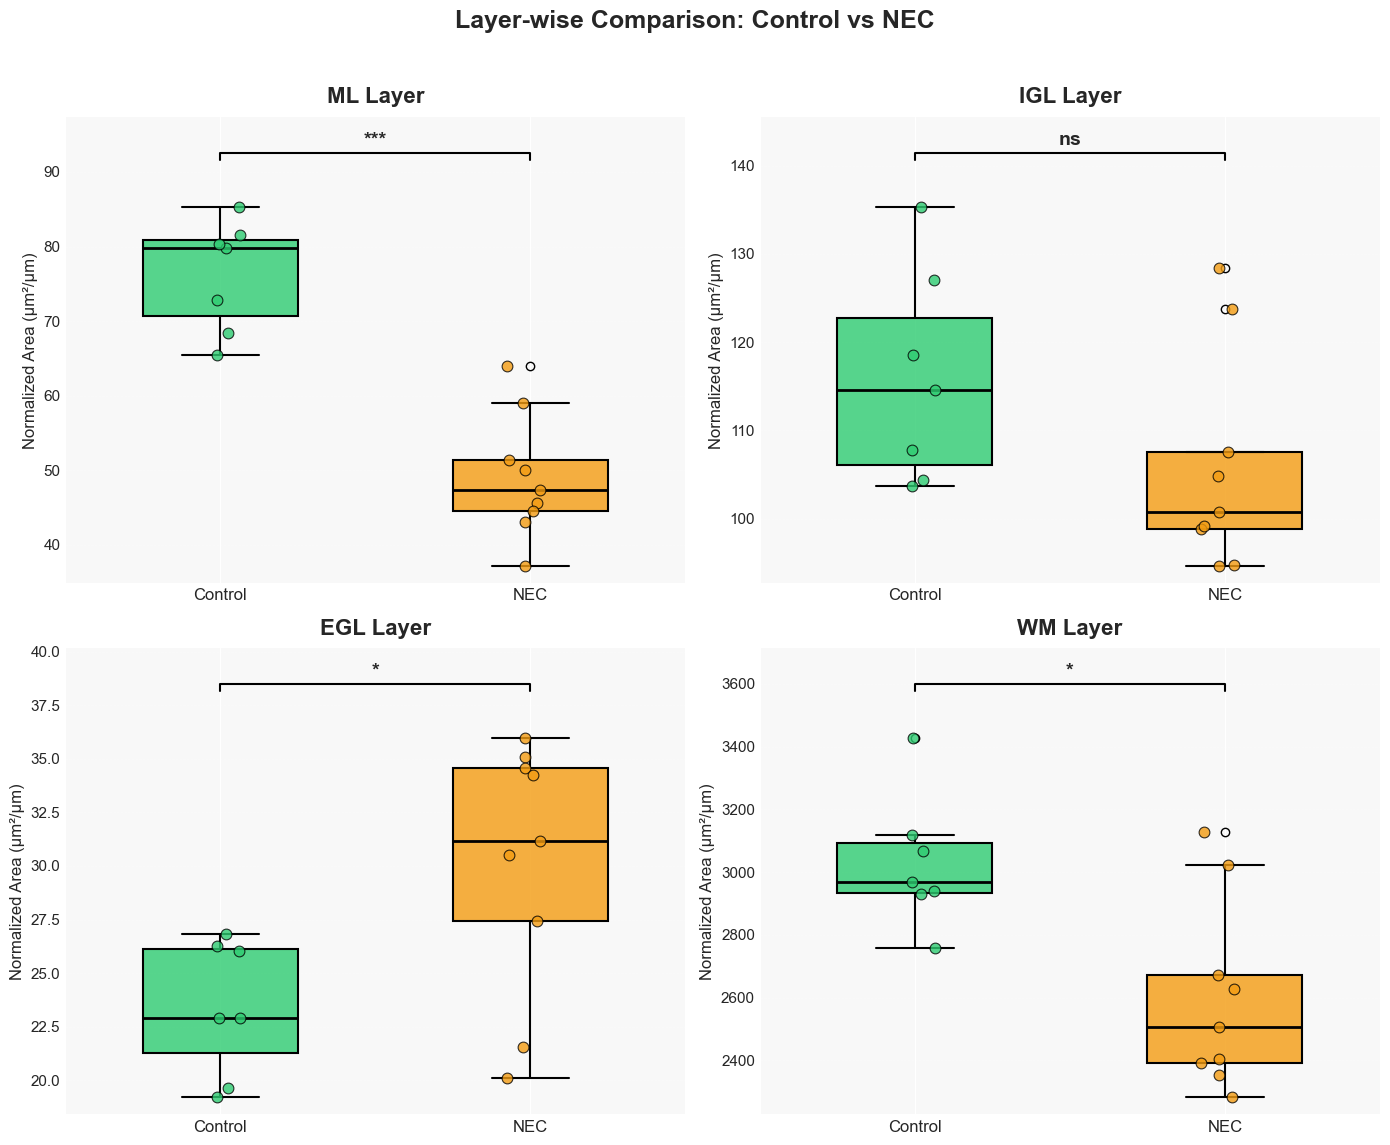

In [14]:
# Create individual box plots for each layer with improved aesthetics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Define colors with slight transparency for better appearance
control_color = '#2ecc71'  # Green
nec_color = '#f39c12'     # Orange
control_color_alpha = '#2ecc71CC'  # Green with transparency
nec_color_alpha = '#f39c12CC'     # Orange with transparency

for idx, layer in enumerate(['ML', 'IGL', 'EGL', 'WM']):
    layer_data = melted_df[melted_df['Layer'] == layer]
    
    if len(layer_data) > 0:
        ax = axes[idx]
        
        # Get data for each group
        control_data = layer_data[layer_data['Sample_type'] == 'Control']['Normalized_Area']
        nec_data = layer_data[layer_data['Sample_type'] == 'NEC']['Normalized_Area']
        
        # Create box plot with custom properties
        bp = ax.boxplot([control_data.values, nec_data.values],
                       labels=['Control', 'NEC'],
                       patch_artist=True,
                       widths=0.5,
                       showmeans=False,
                       meanline=False,
                       medianprops=dict(color='black', linewidth=2),
                       whiskerprops=dict(color='black', linewidth=1.5),
                       capprops=dict(color='black', linewidth=1.5),
                       boxprops=dict(linewidth=1.5, edgecolor='black'))
        
        # Color the boxes with slight transparency
        bp['boxes'][0].set_facecolor(control_color_alpha)
        bp['boxes'][1].set_facecolor(nec_color_alpha)
        
        # Add individual points with jitter
        np.random.seed(42)
        x_control = np.random.normal(1, 0.04, len(control_data))
        x_nec = np.random.normal(2, 0.04, len(nec_data))
        
        # Plot individual points
        ax.scatter(x_control, control_data, alpha=0.8, s=60, color=control_color, 
                  edgecolors='black', linewidth=0.8, zorder=10)
        ax.scatter(x_nec, nec_data, alpha=0.8, s=60, color=nec_color, 
                  edgecolors='black', linewidth=0.8, zorder=10)
        
        # Calculate y-axis limits with extra space for significance markers
        all_values = pd.concat([control_data, nec_data])
        y_min = all_values.min()
        y_max = all_values.max()
        y_range = y_max - y_min
        
        # Set y-axis limits with 25% extra space at top for significance markers
        ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.25 * y_range)
        
        # Add statistical significance if applicable
        if len(control_data) >= 3 and len(nec_data) >= 3:
            _, p_value = stats.mannwhitneyu(control_data, nec_data, alternative='two-sided')
            
            # Calculate bracket position (15% above the highest point)
            y_bracket = y_max + 0.15 * y_range
            
            # Draw significance bracket with better styling
            bracket_height = 0.02 * y_range
            ax.plot([1, 1, 2, 2], 
                   [y_bracket - bracket_height, y_bracket, y_bracket, y_bracket - bracket_height], 
                   'k-', linewidth=1.5)
            
            # Determine significance text
            if p_value < 0.001:
                sig_text = "***"
            elif p_value < 0.01:
                sig_text = "**"
            elif p_value < 0.05:
                sig_text = "*"
            else:
                sig_text = "ns"
            
            # Add significance text
            ax.text(1.5, y_bracket + 0.01 * y_range, sig_text, 
                   ha='center', va='bottom', fontsize=14, fontweight='bold')
        
        # Customize subplot appearance
        ax.set_title(f'{layer} Layer', fontsize=16, fontweight='bold', pad=10)
        ax.set_ylabel('Normalized Area (µm²/µm)', fontsize=12)
        ax.set_xlabel('', fontsize=12)
        
        # Improve grid and background
        ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.5)
        ax.set_facecolor('#F8F8F8')  # Light gray background
        
        # Add reference line at y=0
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        # Customize tick labels
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.set_xticklabels(['Control', 'NEC'], fontsize=12)
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)

# Remove empty subplot if odd number of layers
if len(['ML', 'IGL', 'EGL', 'WM']) % 2 != 0:
    fig.delaxes(axes[-1])

# Add main title with more space
plt.suptitle('Layer-wise Comparison: Control vs NEC', fontsize=18, fontweight='bold', y=0.98)

# Adjust layout with better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save figure
save_figure('individual_layer_boxplots_improved')
plt.show()


## 11. Create Combined Analysis Figure

Saved: final_control_vs_nec_anatomical_order.pdf


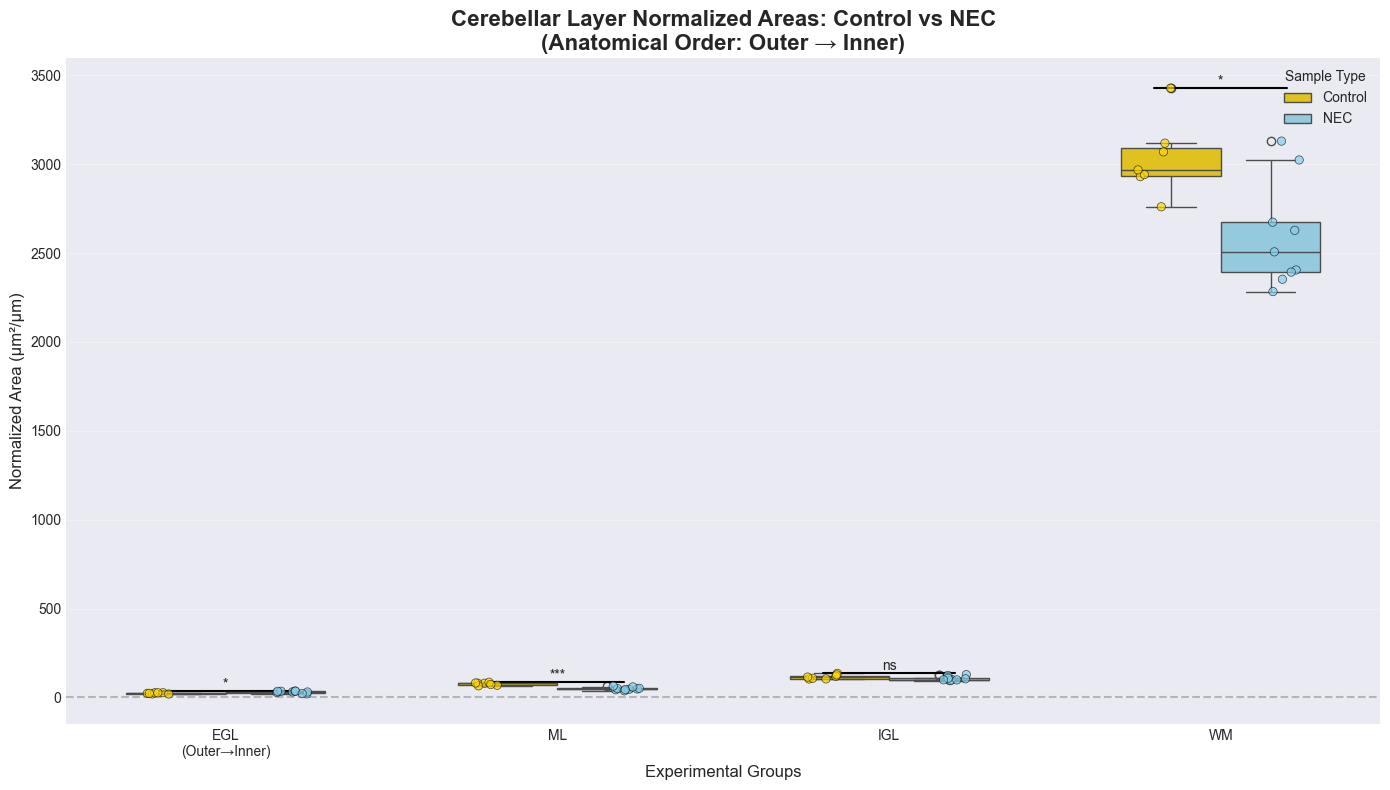

In [15]:
# Create a comprehensive figure similar to the reference image
plt.figure(figsize=(14, 8))

# Define anatomical order
anatomical_order = ['EGL', 'ML', 'IGL', 'WM']  # Outer to Inner

# Prepare data in anatomical order
ordered_data = []
for layer in anatomical_order:
    layer_data = melted_df[melted_df['Layer'] == layer]
    if len(layer_data) > 0:
        ordered_data.append(layer_data)

if ordered_data:
    combined_ordered_df = pd.concat(ordered_data)
    
    # Create box plot with anatomical ordering
    ax = sns.boxplot(data=combined_ordered_df, 
                    x='Layer', 
                    y='Normalized_Area',
                    hue='Sample_type',
                    order=anatomical_order,
                    palette=palette,
                    width=0.6)
    
    # Add individual points
    sns.stripplot(data=combined_ordered_df,
                 x='Layer',
                 y='Normalized_Area',
                 hue='Sample_type',
                 order=anatomical_order,
                 dodge=True,
                 palette=palette,
                 size=6,
                 alpha=0.7,
                 edgecolor='black',
                 linewidth=0.5,
                 ax=ax)
    
    # Add significance brackets for each layer
    for i, layer in enumerate(anatomical_order):
        layer_data = combined_ordered_df[combined_ordered_df['Layer'] == layer]
        control_vals = layer_data[layer_data['Sample_type'] == 'Control']['Normalized_Area']
        nec_vals = layer_data[layer_data['Sample_type'] == 'NEC']['Normalized_Area']
        
        if len(control_vals) >= 3 and len(nec_vals) >= 3:
            _, p_value = stats.mannwhitneyu(control_vals, nec_vals, alternative='two-sided')
            
            # Calculate bracket position
            y_max = layer_data['Normalized_Area'].max()
            y_bracket = y_max + 0.05
            
            # Draw bracket
            x_pos_left = i - 0.2
            x_pos_right = i + 0.2
            
            plt.plot([x_pos_left, x_pos_left, x_pos_right, x_pos_right], 
                    [y_bracket - 0.02, y_bracket, y_bracket, y_bracket - 0.02], 
                    'k-', linewidth=1.5)
            
            # Add significance text
            if p_value < 0.001:
                sig_text = "***"
            elif p_value < 0.01:
                sig_text = "**"
            elif p_value < 0.05:
                sig_text = "*"
            else:
                sig_text = "ns"
            
            plt.text(i, y_bracket + 0.02, sig_text, ha='center', va='bottom', fontsize=10)
    
    # Customize plot
    plt.title('Cerebellar Layer Normalized Areas: Control vs NEC\n(Anatomical Order: Outer → Inner)', 
             fontsize=16, fontweight='bold')
    plt.xlabel('Experimental Groups', fontsize=12)
    plt.ylabel('Normalized Area (µm²/µm)', fontsize=12)
    
    # Update x-axis labels to include layer position
    new_labels = [f'{layer}\n(Outer→Inner)' if i == 0 else layer for i, layer in enumerate(anatomical_order)]
    ax.set_xticklabels(new_labels)
    
    # Add horizontal reference line
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Clean up legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Sample Type', loc='upper right')
    
    # Add grid
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save figure
    save_figure('final_control_vs_nec_anatomical_order')
    plt.show()

## 12. Export Results and Summary

In [16]:
# Save processed data
output_path = output_dir / 'normalized_mouse_cerebellar_measurements.csv'
pivoted_df.to_csv(output_path, index=False)
print(f"\nProcessed data saved to: {output_path.name}")

# Create summary statistics
summary_stats = melted_df.groupby(['Sample_type', 'Layer'])['Normalized_Area'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)

print("\nSummary Statistics by Sample Type and Layer:")
print(summary_stats)

# Save summary statistics
summary_output_path = output_dir / 'summary_stats_control_vs_nec.csv'
summary_stats.to_csv(summary_output_path)
print(f"\nSummary statistics saved to: {summary_output_path.name}")

# Create analysis report
report_path = output_dir / 'mouse_analysis_summary.txt'
with open(report_path, 'w') as f:
    f.write("Mouse Cerebellar Layer Analysis Summary\n")
    f.write("="*50 + "\n\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total samples analyzed: {len(pivoted_df)}\n")
    f.write(f"Control samples: {len(pivoted_df[pivoted_df['Sample_type'] == 'Control'])}\n")
    f.write(f"NEC samples: {len(pivoted_df[pivoted_df['Sample_type'] == 'NEC'])}\n\n")
    
    f.write("Normalization method: Layer Area / (ML_IGL_20µm Perimeter ÷ 2)\n\n")
    
    f.write("Statistical Comparisons (Mann-Whitney U test):\n")
    for layer in ['ML', 'IGL', 'EGL', 'WM']:
        layer_data = melted_df[melted_df['Layer'] == layer]
        control_vals = layer_data[layer_data['Sample_type'] == 'Control']['Normalized_Area']
        nec_vals = layer_data[layer_data['Sample_type'] == 'NEC']['Normalized_Area']
        
        if len(control_vals) >= 3 and len(nec_vals) >= 3:
            _, p_value = stats.mannwhitneyu(control_vals, nec_vals, alternative='two-sided')
            f.write(f"\n{layer} Layer: p-value = {p_value:.4f}")
            if p_value < 0.05:
                f.write(" (Significant)")
    
    f.write("\n\nNotes:\n")
    f.write("- All 60x magnification images were excluded from analysis\n")
    f.write("- Multiple images from the same sample were averaged\n")
    f.write("- Control samples start with 'C', NEC samples start with 'N'\n")

print(f"\nAnalysis report saved to: {report_path.name}")

# List all saved files
print("\n" + "="*50)
print("All files saved to output directory:")
print("="*50)
for file in sorted(output_dir.glob('*')):
    print(f"  - {file.name}")


Processed data saved to: normalized_mouse_cerebellar_measurements.csv

Summary Statistics by Sample Type and Layer:
                   count      mean      std       min       max
Sample_type Layer                                              
Control     EGL        7    23.391    3.135    19.206    26.810
            IGL        7   115.886   11.957   103.718   135.348
            ML         7    76.252    7.403    65.486    85.345
            WM         7  3030.388  208.916  2760.073  3427.378
NEC         EGL        9    30.065    5.892    20.094    35.968
            IGL        9   105.831   12.262    94.664   128.428
            ML         9    49.160    8.215    37.216    64.009
            WM         9  2599.223  299.476  2283.061  3129.462

Summary statistics saved to: summary_stats_control_vs_nec.csv

Analysis report saved to: mouse_analysis_summary.txt

All files saved to output directory:
  - .DS_Store
  - EGL_layer_heatmap_by_type.pdf
  - IGL_layer_heatmap_by_type.pdf
  - ML

## 13. Key Findings Summary
This analysis provides:
1. **Normalized area measurements** for each cerebellar layer in mouse samples
2. **Comparison between Control and NEC groups** with statistical testing
3. **Box plots** showing distribution differences between groups
4. **Heatmaps** for individual sample visualization

### Notes:
- Normalization formula: Layer Area / (ML_IGL_20µm Perimeter ÷ 2)
- Only 20x magnification images were included
- Multiple images per sample were averaged
- Statistical significance tested using Mann-Whitney U test

In [17]:
print("\nMouse cerebellar analysis complete! 🎉")
print("\nKey findings are visualized in the box plots comparing Control vs NEC groups.")


Mouse cerebellar analysis complete! 🎉

Key findings are visualized in the box plots comparing Control vs NEC groups.
